# Código do Projeto Final de Estatística e Módulos Probabilísticos


## 1. Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
# Importando os datasets como dataframes

df_chromecast = pd.read_csv('data\dataset_chromecast.csv')
df_smarttv = pd.read_csv('data\dataset_smart-tv.csv')

In [3]:
# Conversão das taxas para a escala logarítmica

def log10_scale(df, col):
    # Substitui os valores de 0 para NaN, assim garantindo que 
    # sejam mantidos como 0 após a conversão (pois log10(0) = -inf)
    df[col] = df[col].replace(0, np.nan)
    df[col] = np.log10(df[col])
    df[col] = df[col].replace(np.nan, 0.0)
    return df


df_chromecast = log10_scale(df_chromecast, 'bytes_down')
df_chromecast = log10_scale(df_chromecast, 'bytes_up')

df_smarttv = log10_scale(df_smarttv, 'bytes_down')
df_smarttv = log10_scale(df_smarttv, 'bytes_up')

## 2. Estatísticas Gerais


### 2.1. Média, Variância e Desvio Padrão

In [4]:
# Calculando + Arredondando os valores para 3 casas decimais:

chromecast_stats_down = df_chromecast['bytes_down'].agg(['mean', 'std', 'var']).round(3)
chromecast_stats_up = df_chromecast['bytes_up'].agg(['mean', 'std', 'var']).round(3)

smarttv_stats_down = df_smarttv['bytes_down'].agg(['mean', 'std', 'var']).round(3)
smarttv_stats_up = df_smarttv['bytes_up'].agg(['mean', 'std', 'var']).round(3)

# Resultados:
# print('chromecast_stats_down', chromecast_stats_down,
#       'chromecast_stats_up', chromecast_stats_up,
#       'smarttv_stats_down', smarttv_stats_down,
#       'smarttv_stats_up', smarttv_stats_up, sep='\n')

#### Resultados:

|                 | MEAN  | STD   | VAR   |
|:---------------:|:-----:|:-----:|:-----:|
| chromecast_down | 3.799 | 1.291 | 1.666 |
| chromecast_up   | 3.350 | 0.679 | 0.462 |
| smarttv_down    | 2.350 | 2.593 | 6.724 |
| smarttv_up      | 2.157 | 2.028 | 4.113 |



### 2.2 Gráficos

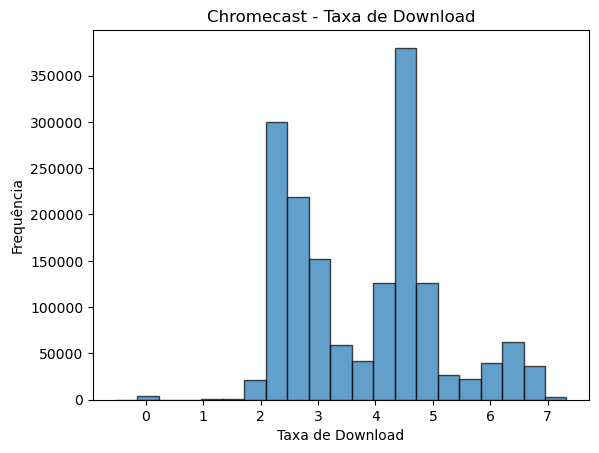

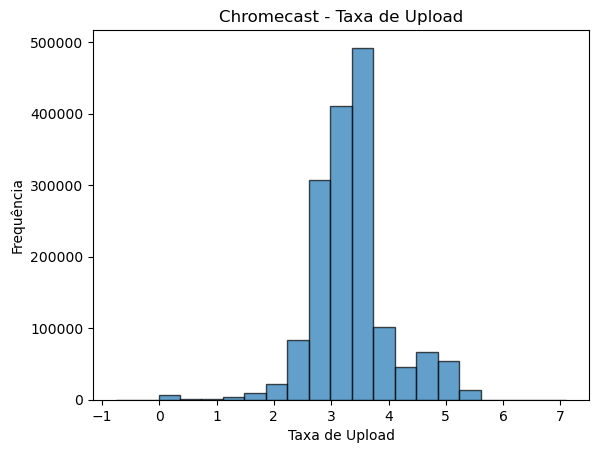

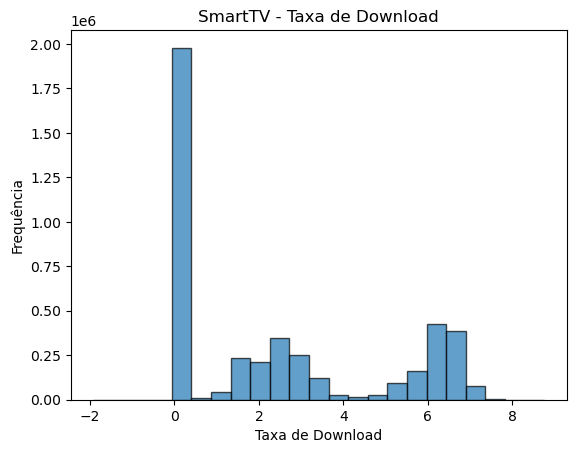

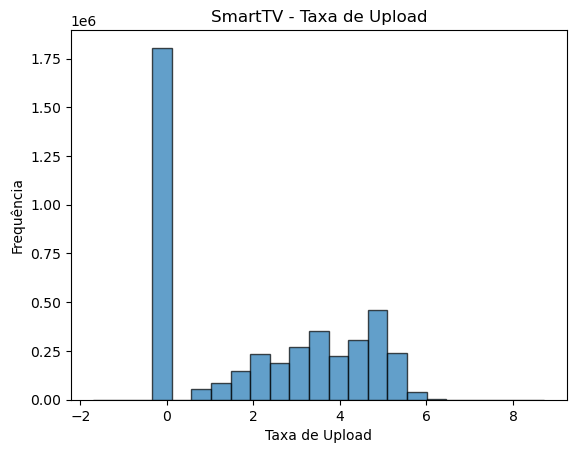

In [5]:
def hist_plot(df, col, device, label):
    # Calcular "bins" usando o método de Sturges
    num_bins = int(1 + np.log2(len(df[col])))

    # Criando o histograma
    plt.hist(df[col], bins=num_bins, edgecolor='black', alpha=0.7)

    plt.xlabel(label)
    plt.ylabel('Frequência')
    plt.title(f'{device} - {label}')
    
    plt.savefig(f'output_data/2_stats_gerais/hist_{device}_{label}.png')
    plt.show()

hist_plot(df_chromecast, 'bytes_down', 'Chromecast', 'Taxa de Download')
hist_plot(df_chromecast, 'bytes_up', 'Chromecast', 'Taxa de Upload')
hist_plot(df_smarttv, 'bytes_down', 'SmartTV', 'Taxa de Download')
hist_plot(df_smarttv, 'bytes_up', 'SmartTV', 'Taxa de Upload')

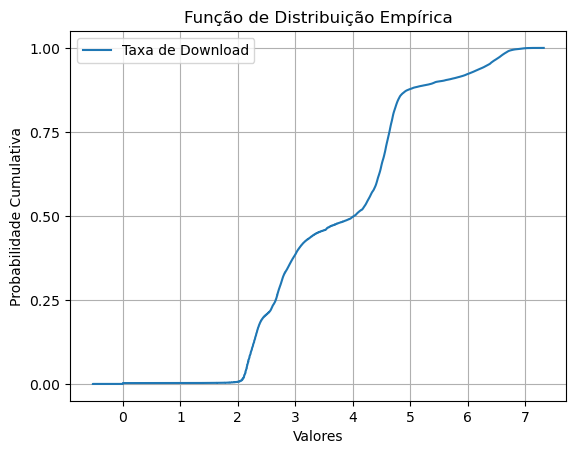

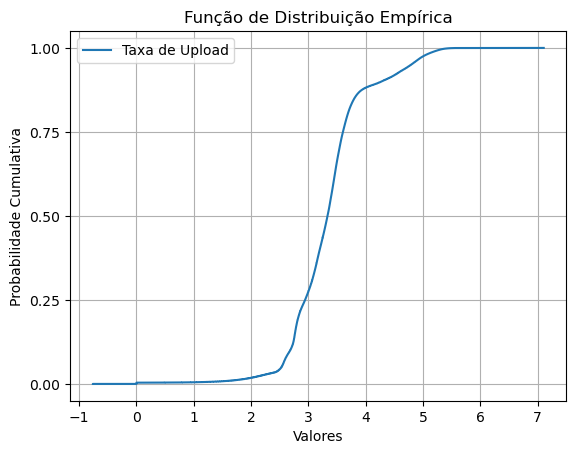

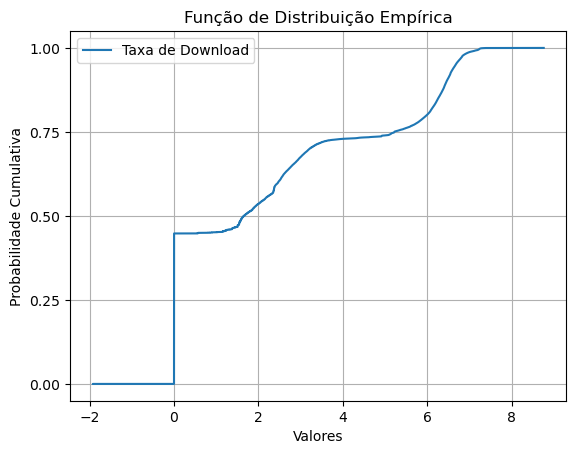

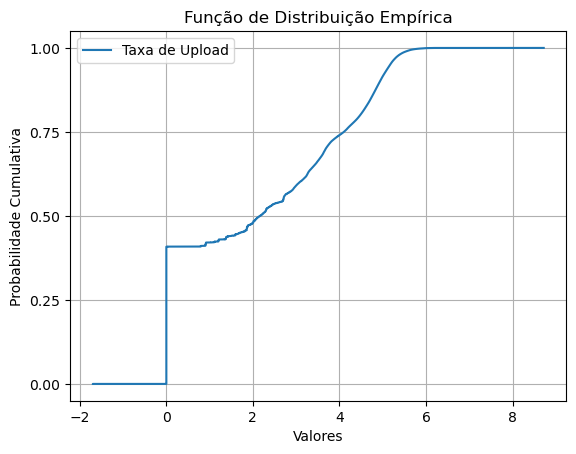

In [6]:
# Função Distribuição Empírica (ECDF)

def ecdf_plot(data, device):

    x = np.sort(data)
    # Calculando a probabilidade acumulada para cada valor:
    y = np.arange(1, len(x) + 1) / len(x)
    
    label = 'Taxa de Download' if data.name == 'bytes_down' else 'Taxa de Upload'

    # Plotando o gráfico
    plt.step(x, y, label=label)

    plt.xlabel('Valores')
    plt.yticks(np.arange(0, 1.1, 0.25))
    plt.ylabel('Probabilidade Cumulativa')
    plt.title('Função de Distribuição Empírica')
    plt.legend()
    plt.grid(True)
    
    plt.savefig(f'output_data/2_stats_gerais/ecdf_{device}_{label}.png')
    plt.show()

ecdf_plot(df_chromecast['bytes_down'], 'Chromecast')
ecdf_plot(df_chromecast['bytes_up'], 'Chromecast')
ecdf_plot(df_smarttv['bytes_down'], 'SmartTV')
ecdf_plot(df_smarttv['bytes_up'], 'SmartTV')

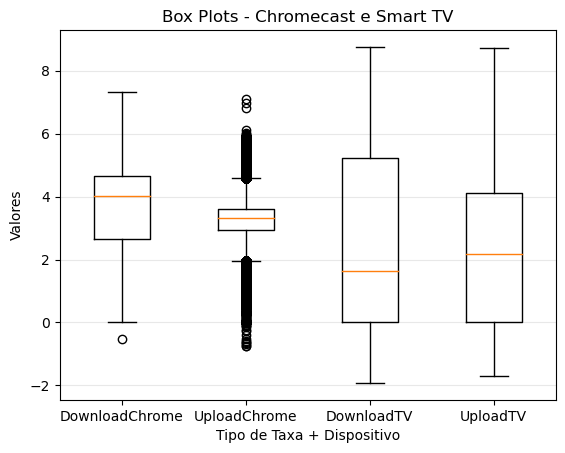

In [7]:

def boxplot(df1, df2, labels):
    # Dados para os box plots
    data_1 = [df1['bytes_down'], df1['bytes_up']]
    data_2 = [df2['bytes_down'], df2['bytes_up']]

    # Rótulos
    box_labels = [labels[0] + 'Chrome', labels[1] + 'Chrome', 
                  labels[0] + 'TV', labels[1] + 'TV']

    # Criando o plot
    fig, ax = plt.subplots()
    ax.boxplot(data_1 + data_2, labels=box_labels, showfliers=True)

    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    
    ax.set(axisbelow=True,
           xlabel='Tipo de Taxa + Dispositivo',
           ylabel='Valores',
           title='Box Plots - Chromecast e Smart TV')
    
    plt.savefig('output_data/2_stats_gerais/boxplot.png')
    plt.show()
    

labels = ['Download', 'Upload']
boxplot(df_chromecast, df_smarttv, labels)


## 3. Estatísticas por Horário

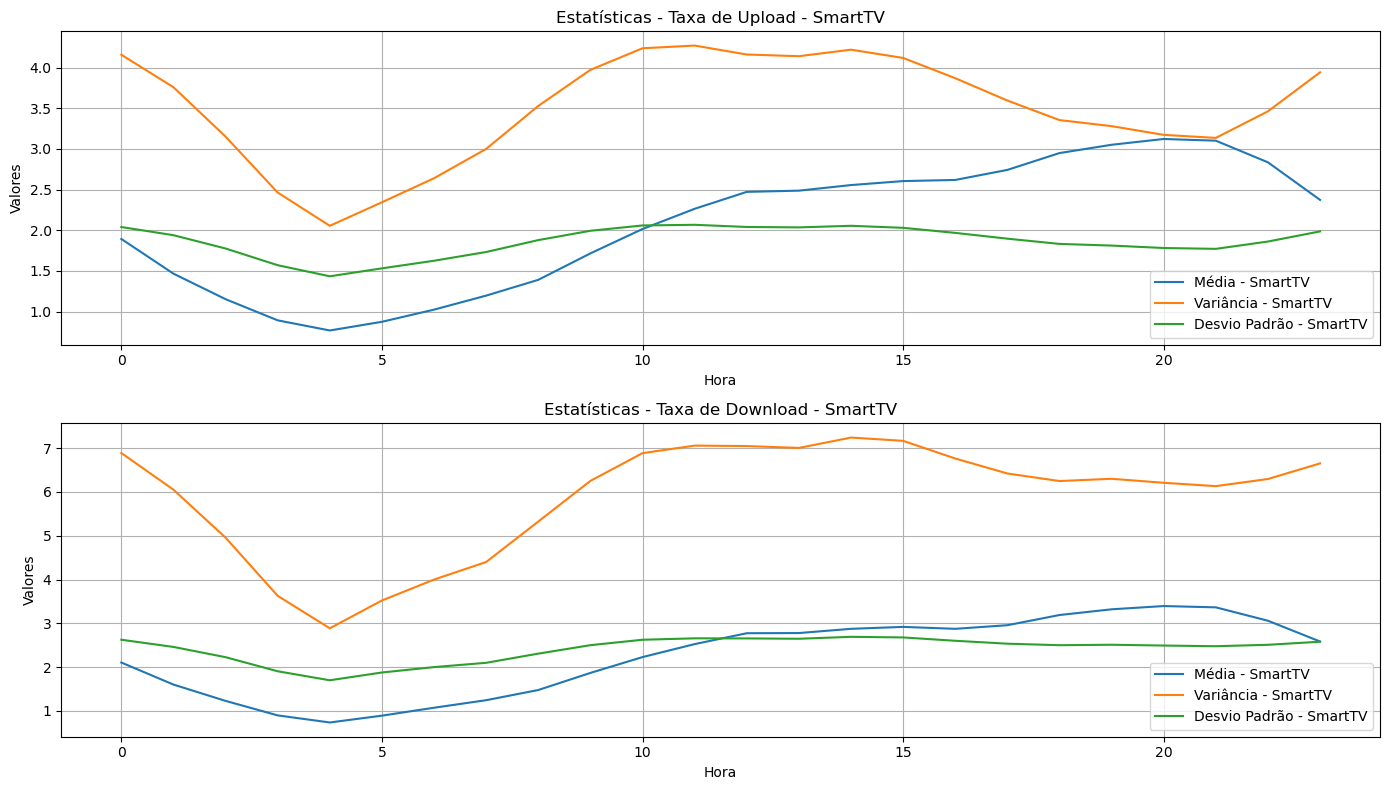

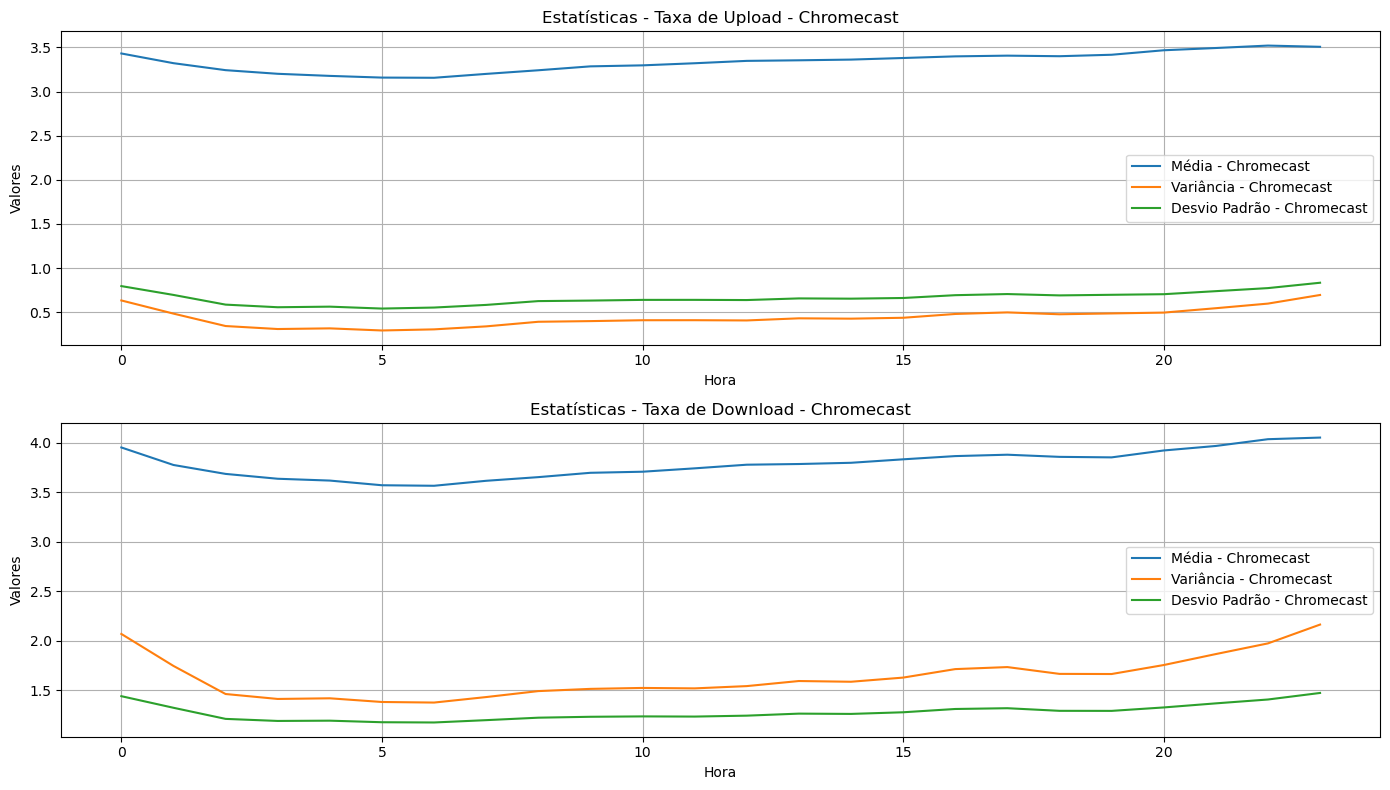

In [8]:
def plot_statistics(df, label):

    # Criando a coluna de horas
    df['date_hour'] = pd.to_datetime(df['date_hour'])
    df['hour'] = df['date_hour'].dt.hour

    grouped_data = df.groupby('hour')

    result_stats = grouped_data.agg({
        'bytes_up': ['mean', 'var', 'std'],
        'bytes_down': ['mean', 'var', 'std']
    }).reset_index()

    # Gráfico
    plt.figure(figsize=(14, 8))

    # Taxa de Upload
    plt.subplot(2, 1, 1)
    plt.plot(result_stats['hour'], result_stats[('bytes_up', 'mean')], label=f'Média - {label}')
    plt.plot(result_stats['hour'], result_stats[('bytes_up', 'var')], label=f'Variância - {label}')
    plt.plot(result_stats['hour'], result_stats[('bytes_up', 'std')], label=f'Desvio Padrão - {label}')
    plt.title(f'Estatísticas - Taxa de Upload - {label}')
    plt.xlabel('Hora')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid()

    # Taxa de Download
    plt.subplot(2, 1, 2)
    plt.plot(result_stats['hour'], result_stats[('bytes_down', 'mean')], label=f'Média - {label}')
    plt.plot(result_stats['hour'], result_stats[('bytes_down', 'var')], label=f'Variância - {label}')
    plt.plot(result_stats['hour'], result_stats[('bytes_down', 'std')], label=f'Desvio Padrão - {label}')
    plt.title(f'Estatísticas - Taxa de Download - {label}')
    plt.xlabel('Hora')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.savefig(f'output_data/3_stats_p_hora/stats_{label}.png')
    plt.show()


label_smarttv = 'SmartTV'
label_chromecast = 'Chromecast'

# Chama a função para gerar os gráficos para Smart TV
plot_statistics(df_smarttv, label_smarttv)

# Chama a função para gerar os gráficos para Chromecast
plot_statistics(df_chromecast, label_chromecast)

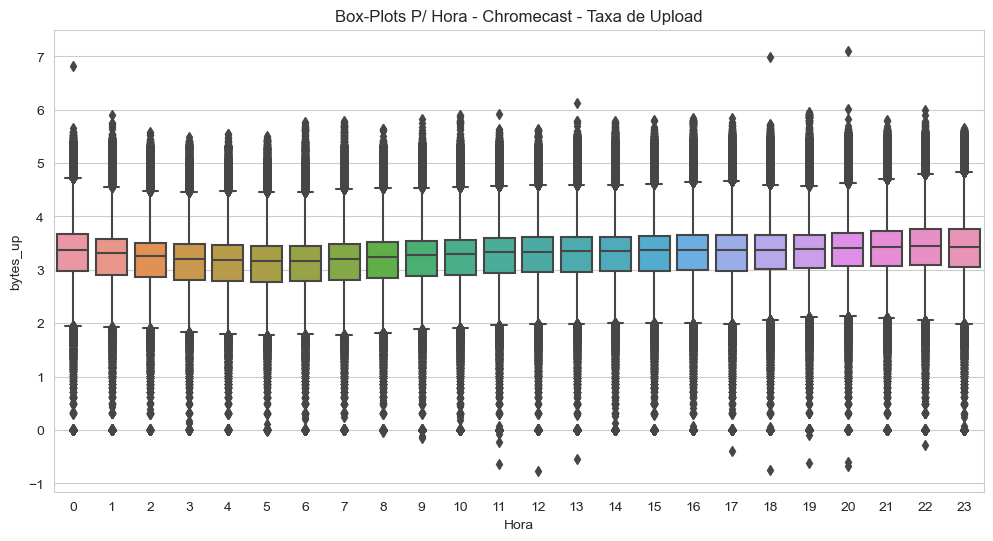

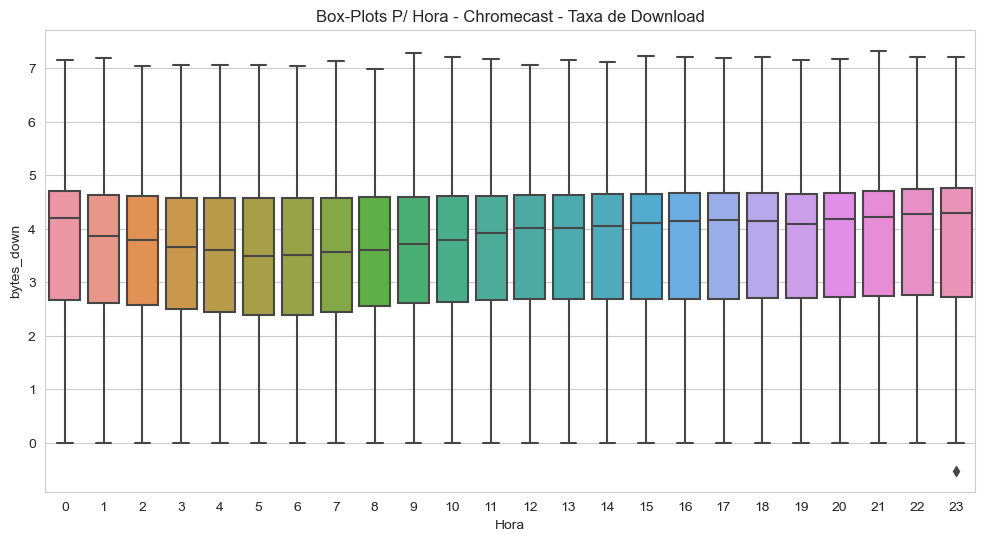

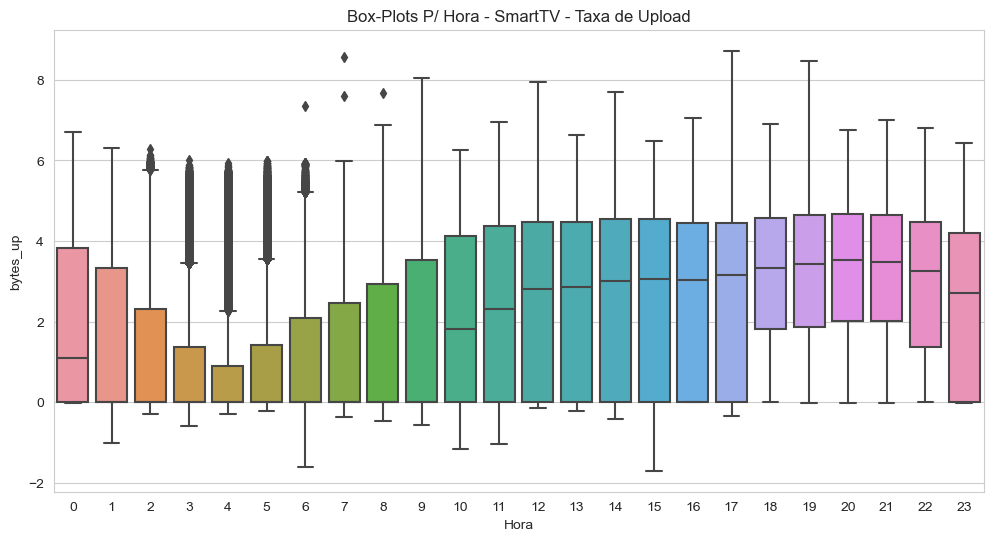

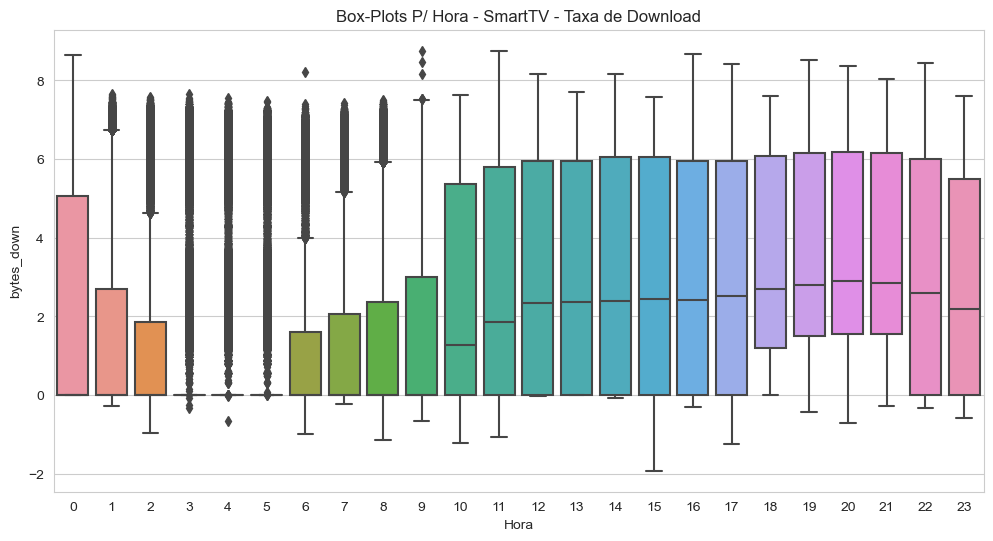

In [13]:
def plot_hourly_boxplots(df, device, column):

    df['date_hour'] = pd.to_datetime(df['date_hour'])
    df['hour'] = df['date_hour'].dt.hour
    device_data = df[[column, 'hour']]

    label = 'Taxa de Download' if column == 'bytes_down' else 'Taxa de Upload'

    # Create a boxplot using Seaborn
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='hour', y=column, data=device_data)
    plt.title(f'Box-Plots P/ Hora - {device} - {label}')
    plt.xlabel('Hora')
    plt.ylabel(f'{column}')
    sns.set_style('whitegrid')
    plt.savefig(f'output_data/3_stats_p_hora/boxplot_{device}_{column}.png')
    plt.show()

# Example of usage for Chromecast and Smart-TV, bytes_up and bytes_down
# Replace df_chromecast and df_smarttv with your actual DataFrames
plot_hourly_boxplots(df_chromecast, 'Chromecast', 'bytes_up')
plot_hourly_boxplots(df_chromecast, 'Chromecast', 'bytes_down')
plot_hourly_boxplots(df_smarttv, 'SmartTV', 'bytes_up')
plot_hourly_boxplots(df_smarttv, 'SmartTV', 'bytes_down')

## 4. Caracterizando os horários com maior valor de tráfego

In [10]:
def mean_by_hour(df):

    df['date_hour'] = pd.to_datetime(df['date_hour'])
    df['hour'] = df['date_hour'].dt.hour
    data_download = df.groupby('hour').agg({'bytes_down': 'mean', 'bytes_up': 'mean'}).reset_index()

    # retorna um dataframe com a média de bytes_down e bytes_up por hora
    return data_download

def highestmean(data, col):
    # retorna a hora com o maior valor de bytes_down e bytes_up
    return data[data[col] == data[col].max()]['hour'].values[0]

data_chromecast = mean_by_hour(df_chromecast)
data_smarttv = mean_by_hour(df_smarttv)

# HMT = Highest Mean Time

HMT_smarttv_down = highestmean(data_smarttv, 'bytes_down')
HMT_smarttv_up = highestmean(data_smarttv, 'bytes_up')

HMT_chromecast_down = highestmean(data_chromecast, 'bytes_down')
HMT_chromecast_up = highestmean(data_chromecast, 'bytes_up')

# Resultados:
# print('HMT_smarttv_down', HMT_smarttv_down,
#       'HMT_smarttv_up', HMT_smarttv_up,
#       'HMT_chromecast_down', HMT_chromecast_down,
#       'HMT_chromecast_up', HMT_chromecast_up, sep='\n')

#### Maiores Médias:

|            | Download | Upload |
|:----------:|:--------:|:------:|
| chromecast |    23    |   22   |
| smart-tv   |    20    |   20   |


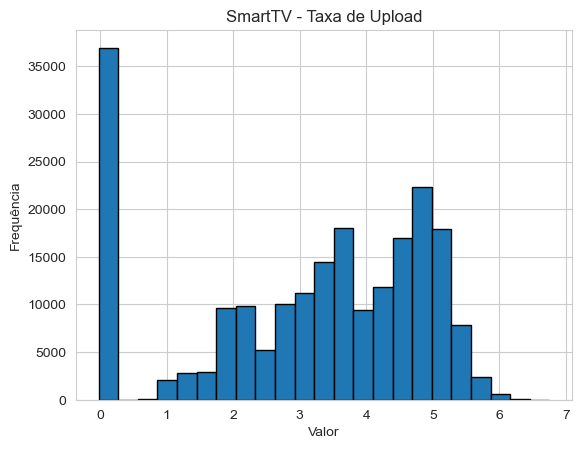

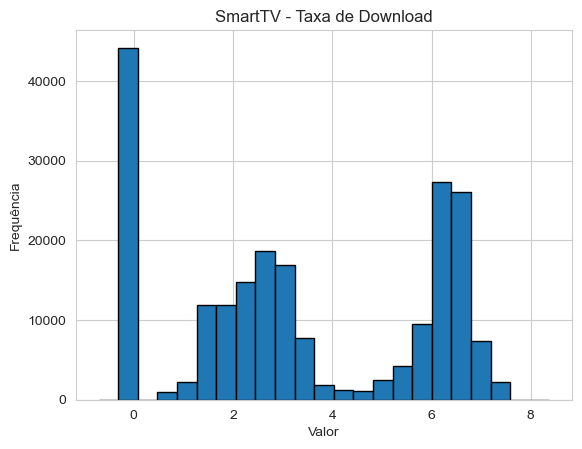

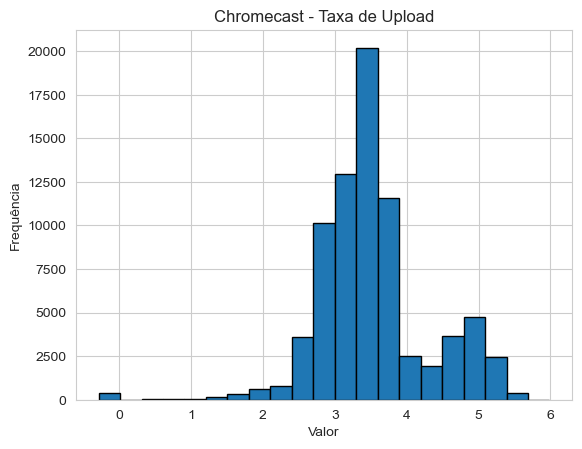

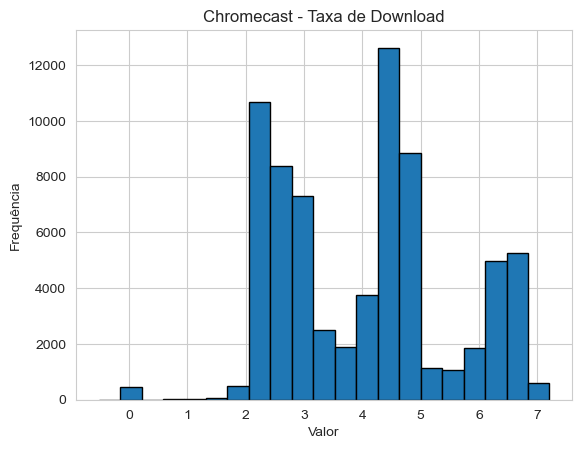

In [11]:
def pltHMT(df, device_type, col, HMT):
    # Filtra os dados para o dispositivo e métrica específicos
    condition = df['date_hour'].dt.hour == HMT
    df_filtered = df[condition]

    # Plota o histograma
    num_bins = int(1 + np.log2(len(df[col])))
    label = 'Taxa de Download' if col == 'bytes_down' else 'Taxa de Upload'
    plt.hist(df_filtered[col], bins=num_bins, edgecolor='black')
    plt.title(f'{device_type} - {label}')
    plt.xlabel('Valor')
    plt.ylabel('Frequência')

    plt.savefig(f'output_data/4_stats/hist_{device_type}_{col}.png')
    plt.show()

# Exemplo de uso
pltHMT(df_smarttv, 'SmartTV', 'bytes_up', HMT_smarttv_up)
pltHMT(df_smarttv, 'SmartTV', 'bytes_down', HMT_smarttv_down)
pltHMT(df_chromecast, 'Chromecast', 'bytes_up', HMT_chromecast_up)
pltHMT(df_chromecast, 'Chromecast', 'bytes_down', HMT_chromecast_down)

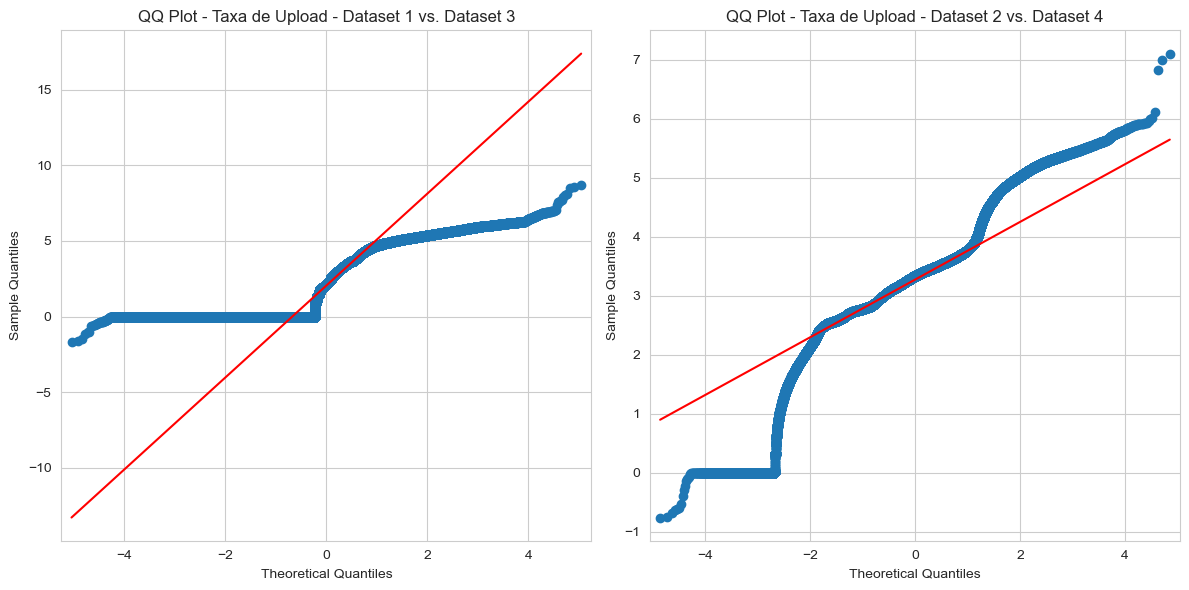

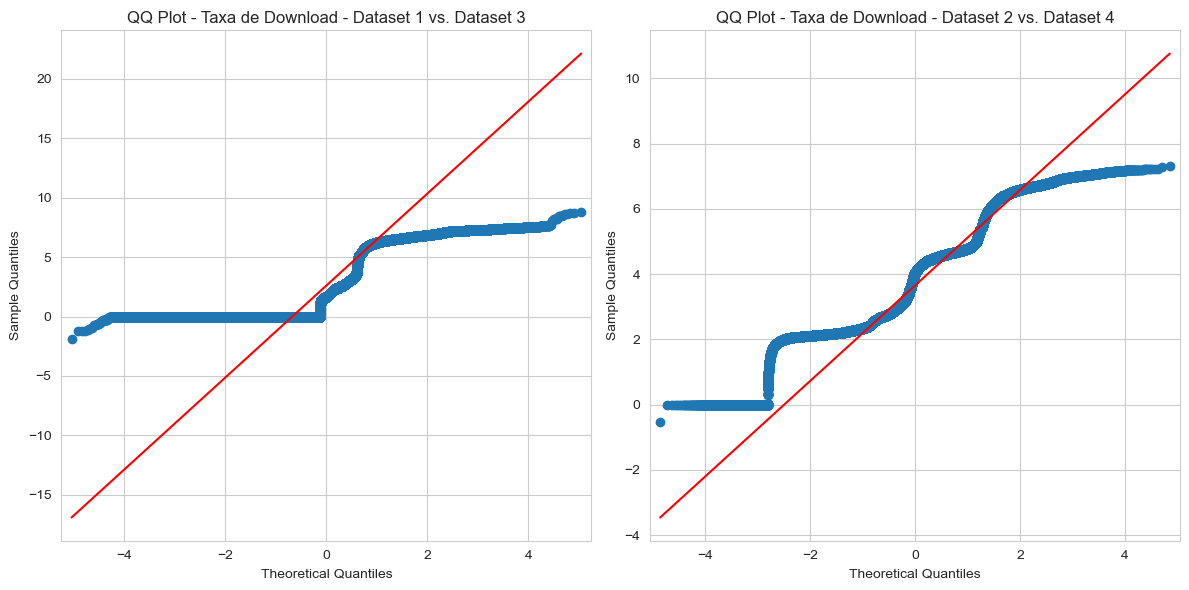

In [12]:
def qq_plot_comparison(df1, df2, df3, df4, col):
    # Filtra os dados para cada dataset e coluna específicados
    data1 = df1[col]
    data2 = df2[col]
    data3 = df3[col]
    data4 = df4[col]

    # Gera os gráficos QQ Plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    label = 'Taxa de Download' if col == 'bytes_down' else 'Taxa de Upload'
    sm.qqplot(data1, line='q', ax=axes[0])
    axes[0].set_title(f'QQ Plot - {label} - Dataset 1 vs. Dataset 3')

    sm.qqplot(data2, line='q', ax=axes[1])
    axes[1].set_title(f'QQ Plot - {label} - Dataset 2 vs. Dataset 4')

    plt.tight_layout()
    plt.savefig(f'output_data/4_stats/qqplot_{col}.png')
    plt.show()

# Exemplo de uso
qq_plot_comparison(df_smarttv, df_chromecast, df_smarttv, df_chromecast, 'bytes_up')
qq_plot_comparison(df_smarttv, df_chromecast, df_smarttv, df_chromecast, 'bytes_down')
